Hello, my name is Artem. I'm going to review your project!

You can find my comments in <font color='green'>green</font>, <font color='blue'>blue</font> or <font color='red'>red</font> boxes like this:

<div class="alert alert-block alert-success">
<b>Success:</b> if everything is done succesfully
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> "Improve" comments mean that there are tiny corrections that could help you to make your project better.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> if the block requires some corrections. Work can't be accepted with the red comments.
</div>

### <font color='orange'>General feedback</font>
* You've worked really hard and submitted a solid project.
* Thank you for structuring the project. It's a pleasure to check such notebooks.
* There are a couple of things that need to be done before your project is complete, but they're pretty straightforward.
* While there's room for improvement, on the whole, your project is looking good.
* I believe you can easily fix it! Good luck!

### <font color='orange'>General feedback (review 2)</font>
* All your hard work has paid off, and now your project is perfect!
* New comments are marked with "review 2" keyword.
* Keep up the good work. Good luck next!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Preparation

## Import Packages

In [1]:
!pip install -U scikit-learn
!pip install lightgbm
!pip install pmdarima
!pip install sktime --user 
!pip install tensorflow
!pip install keras

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0.1)
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [8]:
#import packages
#base packages for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
#packages for time series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import sktime
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
#packages for machine learning 
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
#other
import time
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Success:</b> Great that you've remembered about initial analysis of the uploaded file.
</div>

## Download Data

In [3]:
#import training data
try:
    df = pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

## Data Information

In [4]:
df.info()
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime',inplace=True)
df.sort_index(inplace=True)
print(df.index.is_monotonic)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
True


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Looking at the dataframe, there are two columns: `datetime` and `num_orders`. I converted `datetime` from a string to a datetime index. There are no missing variables in this dataset and, as far as `num_orders`, the mean and median are close enough to where I am unconcerned about outlier issues. 

<div class="alert alert-block alert-success">
<b>Success:</b> Data loading was done well!
</div>

# Training and Testing

## Splitting Data

In [5]:
#hourly resampled data
df = df.resample('1H').sum()
#first differenced data
df_diff = df.diff().dropna()
#creating training and testing sets.
train, test = train_test_split(df,test_size=.1,shuffle=False)

I resampled the data to an hourly level. While this allows us to keep a large sample size. I think there would also be some value in converting it to daily data to help the models recognize trends. 

Additionally, I created a dataset of the first difference of the data to be used later on. 

<div class="alert alert-block alert-success">
<b>Success:</b> Resampling was done correctly!
</div>

## Differencing

In [ ]:
#Running a Dickey Fuller Test
result = adfuller(train.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

I looked at the dickey fuller statistic to see if the data is stationary. According to the test, we can reject the hypothesis that the data is non-stationary. This would point towards using the non-differenced data in this situation, but the next section brought about some concerns with focusing solely on the non-differenced data.

### Autocorrelation and Partial Autocorrelation graphs

In [ ]:
# Plot the Original, First Differenced, and Seasonal Decomposed Series
fig, axes = plt.subplots(2, 3,figsize=(20,10))
#original
axes[0,0].plot(train); axes[0, 0].set_title('Original Series')
#plot the autocorrelation
plot_acf(train,ax = axes[0,1]);
#plot the partial autocorrelation
plot_pacf(train,ax = axes[0,2]);
#differenced
axes[1,0].plot(train.diff()); axes[1, 0].set_title('Differenced Series')
#plot the autocorrelation
plot_acf(train.diff().dropna(),ax=axes[1,1]);
#plot the partial autocorrelation
plot_pacf(train.diff().dropna(),ax = axes[1,2]);

In [ ]:
#seasonal
seasonal_decompose(train, model='additive').plot(); 

<div class="alert alert-block alert-info">
<b>Improve (review 2): </b> It would be better if seasonality was visualized on smaller interval.
</div>

As you can see from the above graphs, the original series seems to have a slight linear trend. This shows up when looking at how the autocorrelations are all significantly positive and when looking at the seasonal decomposition. Contrastingly, the differenced series only has three significant autocorrelations. They are the last two periods and the period 24 hours ago. 

Regarding the partial autocorrelations, the fact that lags going back 24 periods are significant lets us know that the ideal models are going to need a significant number of lagged variables. |

<div class="alert alert-block alert-success">
<b>Success:</b> Data was split right.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Please make seasonal decomposition and visualize trend and seasonality.
</div>

## Model Creation

In [6]:
def plot_forecast(series_train, series_test, forecast):
    #calculate the Root Squared Mean Error
    RMSE = mean_squared_error(series_test, forecast, squared=False)
    #convert the forecast array to a dataframe
    forecast = pd.DataFrame(data=forecast,index=series_test.index, columns=['num_orders'])
    #plot the training, testing and forecasting data
    plt.figure(figsize=(15, 6))
    plt.title(f"RMSE:{RMSE:.2f}")
    plt.plot(series_train,label="train", color="b")
    plt.plot(series_test,label="test", color="g")
    plt.plot(forecast,label="forecast", color="r")
    plt.legend(prop={"size": 10})
    plt.xlim(left=datetime.date(2018, 7, 1))
    plt.show()

This function is used to plot the number of orders over time with the predictions on top of the true values. I trimmed the x-axis on the left to make the predicted aspect of the model easier to see.

### Linear Regression

In [50]:
def make_features(data, lags, rolling_mean_size):
    data_new = data.copy()
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    for lag in range(1, lags + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
    data_new['rolling_mean'] = (
        data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    data_new.dropna(inplace=True)
    X = data_new.drop('num_orders',axis=1).values
    y = data_new['num_orders'].values
    return X, y
def best_features(data,max_lag,max_rolling_mean_size,n_splits):
    RMSE = []
    tscv = TimeSeriesSplit(n_splits = n_splits)
    for i in range(1,max_lag):
        for j in range(1,max_rolling_mean_size):
            X,y = make_features(data,i,j)
            RMSE_cv = []
            for train_index, test_index in tscv.split(X):
                cv_train_x, cv_test_x = X[train_index], X[test_index]
                cv_train_y, cv_test_y = y[train_index], y[test_index]
                model = LinearRegression()
                model.fit(cv_train_x,cv_train_y)
                target_pred_test = model.predict(cv_test_x)
                RMSE_cv.append(mean_squared_error(cv_test_y, target_pred_test, squared=False))
            RMSE.append([i,j,np.array(RMSE_cv).mean()])
    return RMSE[np.array(RMSE)[:,2].argmin()]

best_components = best_features(train,30,30,10)
print(best_components)

[29, 23, 25.995882366330353]


<div class="alert alert-block alert-success">

<b>Success:</b> Great that `make_features` don't change global variable.
</div>

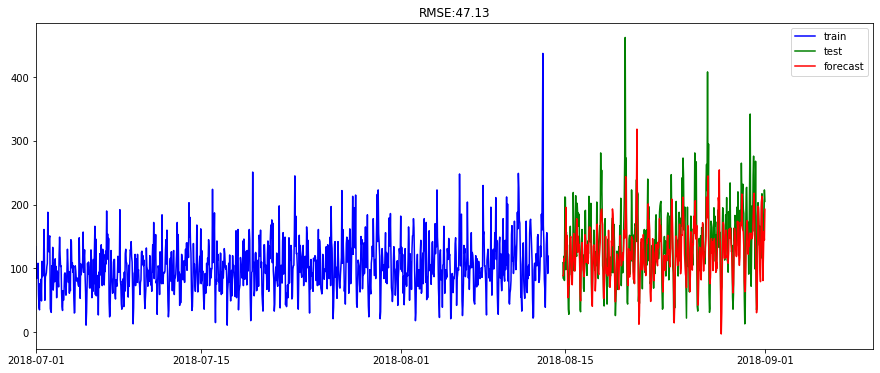

In [51]:
X_train, y_train = make_features(train,best_components[0],best_components[1])
X_test, y_test = make_features(test,best_components[0],best_components[1])
model = LinearRegression()
model.fit(X_train, y_train)
target_pred_test = model.predict(X_test)
plot_forecast(train,test[max(best_components[0],best_components[1]):],target_pred_test)

<div class="alert alert-block alert-success">
<b>Success:</b> Great visualization!
</div>

In this section, I created a function to find the optimal number of lags and moving average length. This function found that for the optimal number of lags was 29 and the optimal length of the moving average was 23. This provided a RMSE of 26, but when running it with the test data, the RMSE was 47. Yet, comparing the RMSE values is not valid since the sizes of the testing sets were different in the cross validated sets compared to the testing set. 

### Long Term Short Memory Model

[[24.271912735017214]]
[[24.271912735017214], [29.0292372255886]]
[[24.271912735017214], [29.0292372255886], [29.633504686314815]]
[[24.271912735017214], [29.0292372255886], [29.633504686314815], [33.1890933836498]]
[[24.271912735017214], [29.0292372255886], [29.633504686314815], [33.1890933836498], [41.92940820449481]]
[[26.25357432793994]]
[[26.25357432793994], [30.24953047892295]]
[[26.25357432793994], [30.24953047892295], [28.797112078431258]]
[[26.25357432793994], [30.24953047892295], [28.797112078431258], [43.15813606351589]]
[[26.25357432793994], [30.24953047892295], [28.797112078431258], [43.15813606351589], [37.75175794096065]]
[[25.952858968786586]]
[[25.952858968786586], [29.905650546672913]]
[[25.952858968786586], [29.905650546672913], [30.25493094326459]]
[[25.952858968786586], [29.905650546672913], [30.25493094326459], [27.025178873122886]]
[[25.952858968786586], [29.905650546672913], [30.25493094326459], [27.025178873122886], [54.06578672948707]]
[[29.958912247149343]]
[

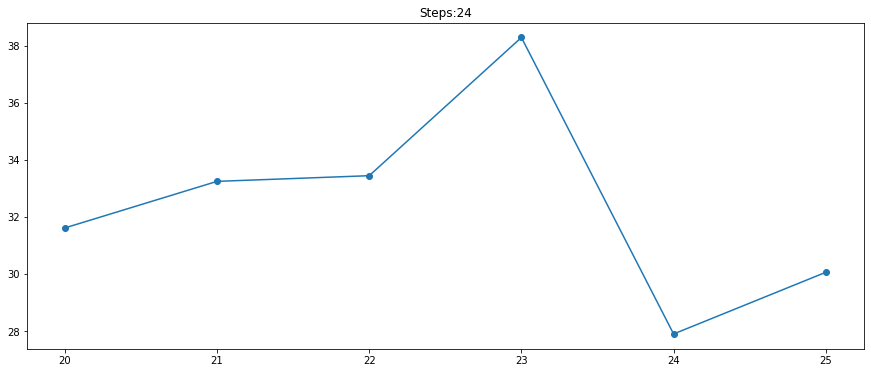

In [56]:
def sampling(sequence, n_steps):
    X, Y = list(), list()
    for i in range(len(sequence)):
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
        x, y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)

    return np.array(X), np.array(Y)

def best_steps(train,max_n_steps,n_splits):
    RMSE = []
    tscv = TimeSeriesSplit(n_splits = n_splits)
    for n_steps in range(20,max_n_steps):
        RMSE_cv = []
        X_train, y_train = sampling(train['num_orders'].tolist(), n_steps)
        for train_index, test_index in tscv.split(X_train):
            cv_train_x, cv_test_x = X_train[train_index], X_train[test_index]
            cv_train_y, cv_test_y = y_train[train_index], y_train[test_index]
            model = Sequential()
            model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')
            cv_train_x = cv_train_x.reshape((cv_train_x.shape[0], cv_train_x.shape[1], 1))
            cv_test_x = cv_test_x.reshape((cv_test_x.shape[0], cv_test_x.shape[1], 1))
            model.fit(cv_train_x,cv_train_y, epochs=100, verbose=0)
            LTSM_forecast = model.predict(cv_test_x)
            RMSE_cv.append([mean_squared_error(cv_test_y, LTSM_forecast, squared=False)])
            print(RMSE_cv)
        RMSE.append([n_steps,np.array(RMSE_cv).mean()])
    RMSE_graph = pd.DataFrame(data=RMSE, columns=['n_steps','RMSE'])
    RMSE_min = RMSE_graph['RMSE'].min()
    steps_min = RMSE_graph.loc[RMSE_graph['RMSE'] == RMSE_min,'n_steps'].values[0]
    plt.figure(figsize=(15, 6))
    plt.title("Steps:{}".format(steps_min))
    plt.plot(RMSE_graph['n_steps'], RMSE_graph['RMSE'], '-o')
    return steps_min


best_step = best_steps(train,26,5)

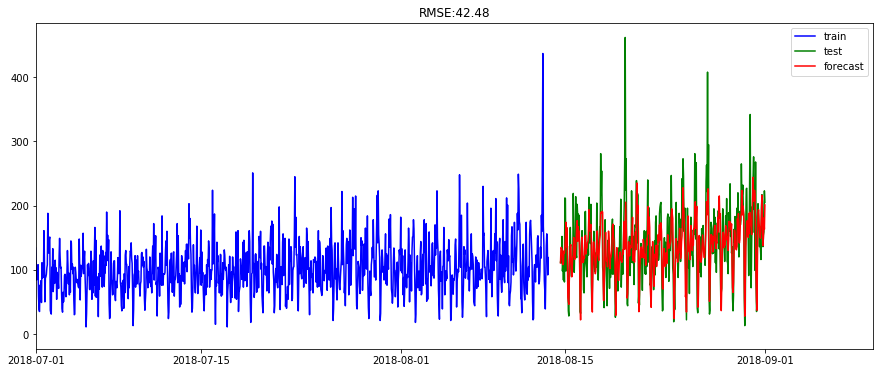

In [60]:
X_train, y_train = sampling(train['num_orders'].tolist(),best_step)
X_test, y_test = sampling(test['num_orders'].tolist(), best_step)
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(best_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
model.fit(X_train,y_train, epochs=100, verbose=0)
LTSM_forecast = model.predict(X_test)
plot_forecast(train,test[best_step:],LTSM_forecast)

In this section, I created a Long Term Short Memory Model. A Long Term Short Memory Model is a type of Recurring Neural Network that can use long term patterns along with short term patterns to create a network. 

For more information on the model, I would suggest watching this youtube video: https://www.youtube.com/watch?v=WCUNPb-5EYI. 

For this model, I created a function that calculates the optimal number of steps (otherwise known as lags) to include for each observation. 

In this instance, a 24 step model was optimal, with a RMSE of around 28. When running the model with the test data, the RMSE was 42.5. As with above, these numbers are not compareable but this model did seem to outperform the linear model.

<div class="alert alert-block alert-danger">

<b>Needs fixing:</b> "n_steps", "lag_size" and "rolling_mean_size" are tuned on test set. We can't tune parameters this way. Please use cross validation with TimeSeriesSplit: https://stackoverflow.com/questions/56546881/using-gridsearchcv-with-timeseriessplit
</div>

<div class="alert alert-block alert-success">
<b>Success (review 2):</b> Good job!
</div>

# Overall Conclusion

Overall, predicting the hourly number of ordered taxis is always going to be a difficult task. There is a lack of data to account for yearly trends, such as holidays, and the data seems to be mostly random noise. 

As far as model choice, the linear regression was much faster to run, but had approximately a 10% higher RMSE. 

In the end, I think the addition of other variables, such as weather, could be incredibly helpful in improving the model. I would recommend the web scraping of weather information for each day and the re-running of the models to see how it changes their performance.

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see conclusion in the end of the project!
</div>